 # Lec 02. DCGAN with CIFAR10 datasets
이번 실습에서는 CIFAR10 데이터셋로부터 새로운 이미지를 생성하기 위해 DCGAN을 적용해보겠습니다. 이번 실습은 다음과 같은 내용을 포함합니다.
- Generator pytorch로 구현하기
- Discriminzator pytorch로 구현하기
- Generator를 통한 image 생성 확인하기
- [PyTorch-GAN](https://github.com/eriklindernoren/PyTorch-GAN)를 통한 다양한 Generative adversarial networks 확인

# CIFAR10 datasets
CIFAR10을 먼저 소개하면 32x32 의 작은 이미지를 10개의 분류로 묶어 놓은 데이터 셋으로써 과거에는 연구용으로 많이 활용되었으나 최근은 소개 혹은 예제용으로 많이 활용되는 데이터 셋입니다.

Cifar10에서는 총 60,000개의 데이터 셋으로 이루어져 있으며, 그 중 50,000개가 training set 이고 10,000개가 test set 으로 이루어져습니다

<br/> 

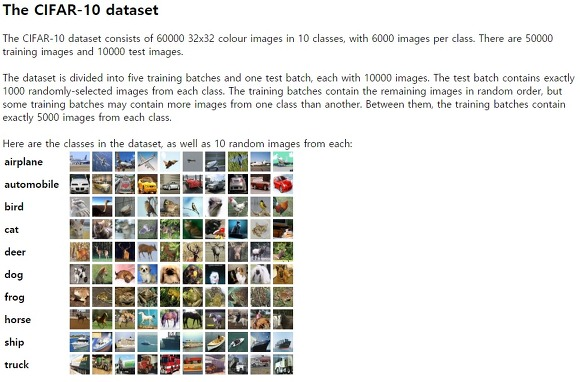






In [ ]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable

cudnn.benchmark = True

## Generator

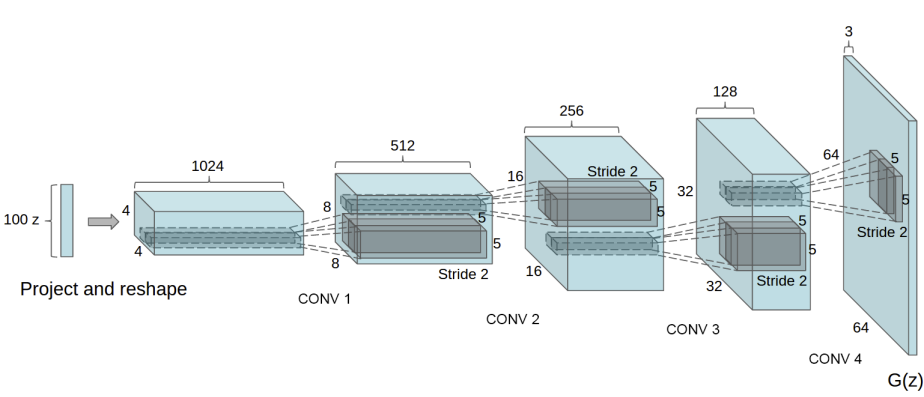

Generator, G는 잠재 공간의 벡터(z)를 데이터 공간으로 매핑하게  디자인 되었습니다. 

우리의 데이터는 이미지이기 때문에, z를 데이터 공간으로 변환하는 것은 궁극적으로 학습 데이터와 같은 사이즈(3 x64 x 64)의 RGB 이미지를 만드는 것과 같습니다. 

실제로, 이것은 2d batch norm 레이어와 Relu 활성화 함수와 짝을 이루는 2차원의 strided convolutional transpose layer들을 통해 이루어집니다. 

인풋 데이터의 범위를 [-1,1]로 조정하기 위해 generator의 아웃풋은 tanh 함수를 거칩니다. 

Conv-transpose 레이어 뒤에 Batch norm function이 위치하는 것이 DCGAN에서 아주 중요한 사항입니다.

 Batch norm function은 학습하는 동안에 그래디언트가 흐를 수 있게 돕습니다.

In [ ]:
class Generator(nn.Module):
    def __init__(self, args):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(in_channels = args.nz, out_channels = args.ngf * 8,kernel_size = 4,stride = 1, padding = 0, bias=False),
            nn.BatchNorm2d(args.ngf * 8),
            nn.ReLU(True),
           
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(args.ngf * 8, args.ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(args.ngf * 4),
            nn.ReLU(True),
        
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(args.ngf * 4, args.ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(args.ngf * 2),
            nn.ReLU(True),
         
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(args.ngf * 2, args.ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(args.ngf),
            nn.ReLU(True),
        
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(args.ngf, args.nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
          output = 
          return output

## Discriminator

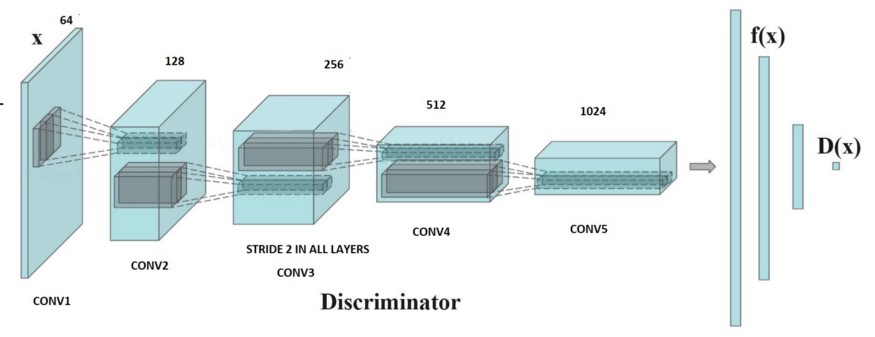

Discriminator, D는 이미지를 인풋으로, 인풋 이미지가 진짜일 확률을 아웃풋으로 하는 이진 분류(binary classification) 네트워크입니다.

D는 3 x 64 x 64 이미지를 입력받아, 여러 개의 Conv2d 레이어, BatchNorm2d 레이어, LeakyReLU 레이어를 지나고, 최종적으로 시그모이드 함수를 거친 확률 값을 아웃풋을 출력합니다. 

이 문제(태스크)를 위해 필요하다면 더 많은 레이어들로 확장될 수 있지만, strided convolution, Batch Norm, LeakyReLUs를 사용하는 데에도 의미가 있습니다. 

DCGAN 논문은 네트워크가 자체적인 풀링 기능을 학습할 수 있다는 점에서 downsample을 위한 풀링보다는 strided convolution을 사용하는 것이 좋다고 이야기합니다.

또한 G와 D의 학습과정에서 아주 중요한 그래디언트의 흐름이 batch norm과 leaky relu 함수를 통해 잘 일어날 수 있다고 이야기합니다

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, args):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(in_channels= args.nc, out_channels= args.ndf, kernel_size= 4,stride = 2,padding = 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
           
            # state size. (ndf) x 32 x 32
            nn.Conv2d(args.ndf, args.ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(args.ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
          
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(args.ndf * 2, args.ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(args.ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
          
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(args.ndf * 4, args.ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(args.ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
         
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(args.ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        output = 
        return output.view(-1, 1).squeeze(1)

In [ ]:
# custom weights initialization called on netG and netD

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

## Hyperparameter 설정

In [ ]:
paser = argparse.ArgumentParser()

args = paser.parse_args("")

args.n_epochs =  
# number of epochs of training
args.batch_size = 
# size of batches
args.lr =  
# adam learning rate
args.b1 =  
# adam: decay of first order momentum of gradient
args.b2 =  
# adam: decay of first order momentum of gradient

args.nz = 100 # dimensionality of the latent space
args.ngf = 
# number of generator filters
args.ndf = 
# number of discriminator filters
args.nc = 3
args.print_every = 50

cudnn.benchmark = True

#set manual seed to a constant get a consistent output
manualSeed = random.randint(1, 10000)
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Dataset / model / loss 설정

In [ ]:
#loading the dataset
dataset = dset.CIFAR10(root="./data", download=True,
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=args.batch_size,
                                         shuffle=True, num_workers=2)

#checking the availability of cuda devices
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# set model
netG = Generator(args).to(device)
netG.apply(weights_init)

netD = Discriminator(args).to(device)
netD.apply(weights_init)

# set binary_cross_entropy loss
criterion = 

 # Optimizers
optimizer_G = optim.Adam(netG.parameters(), lr=args.lr, betas=(args.b1, args.b2))
optimizer_D = optim.Adam(netD.parameters(), lr=args.lr, betas=(args.b1, args.b2))

cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

# Training

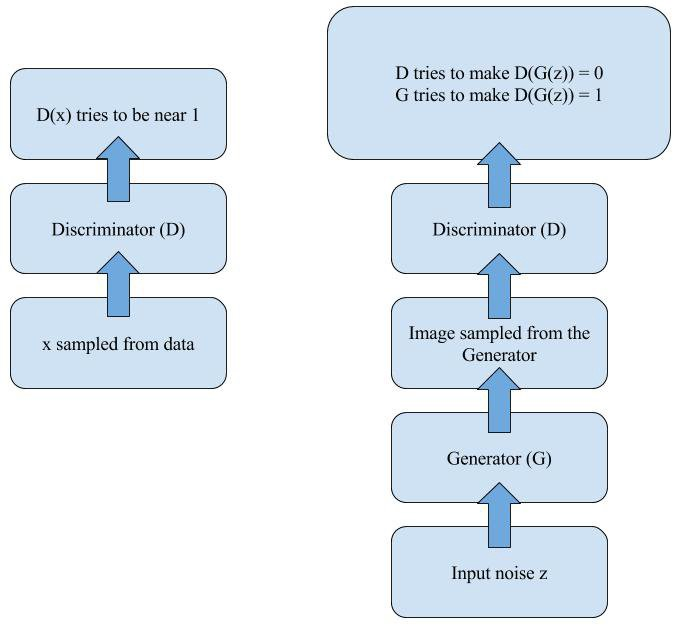

이제 GAN 모듈을 정의했고 모델을 훈련시키고자 합니다.
GAN을 훈련시킬때는 하이퍼 파라미터 설정에 굉장히 민감합니다.
잘못된 하이퍼 파라미터 설정은 무엇이 잘못되었는지 설명이 거의 되지 않으채로 모드 붕괴(mode collapse)로 이어지기 때문입니다. 

여기서는 Goodfellow의 논문에 나오는 알고리즘을 따라서 학습할 것입니다. 
다시 말해, 저희는 "진짜 이미지와 가짜 이미지에 대한 각기 다른 미니 배치를 구성"할 것이고 또한 G의 목적 함수를 log(D(G(z))를 최대화하는 것으로 조정할 것입니다.
학습은 두 개의 메인 파트로 나뉩니다.
파트 1은 D를 업데이트하는 것이고, 파트 2는 G를 업데이트하는 것입니다.

## Part 1 - Train the Discriminator
Discriminator의 목적은 인풋으로 주어진 진짜 혹은 가짜 이미지를 올바르게 분류할 확률을 키우는 것입니다. 따라서 log(D(x))+log(1-D(G(z)))를 극대화 합니다.

- 트레이닝 세트로부터 진짜 샘플을 가져와 배치를 구성한 뒤 D를 거치게 해 loss를 계산한 후 (logD(x)) backpropagation을 합니다. 이어서 generator로 만든 가짜 샘플로 배치를 구성한 뒤 D를 거치게 합니다. 마지막으로 loss를 계산하고(log(1-D(G(z))) backpropagation을 합니다. 
- 이제 모든 진짜 이미지, 가짜 이미지 배치에서의 그래디언트를 모두 합해 discriminator의 opitimizer의 step을 호출합니다.


## Part 2 - Train the Generator
더 나은 가짜 이미지를 만들기 위한 노력으로 log(1-D(G(z)))를 최소화함으로써 generator를 훈련시키고자 합니다. 하지만 언급한 것과 같이 학습 초기에 충분한 그래디언트를 제공하지 못한다는 단점을 가지고 있어, log(D(G(z)))를 최대화하는 방향으로 수정하였습니다. 

- Generator의 아웃풋을 진짜 레이블을 이용해 G의 loss를 계산, G의 그래디언트 계산, 그리고 최종적으로 optimizer step을 이용해 G의 파라미터를 업데이트합니다.


In [ ]:
g_loss = []
d_loss = []

for epoch in range(args.n_epochs):
    for i, data in enumerate(dataloader, 0):
        
        real_img = data[0].to(device)
        batch_size = real_img.size(0)

        label = Variable(Tensor(batch_size).fill_(1.0), requires_grad=False)
        fake_label = Variable(Tensor(batch_size).fill_(0.0), requires_grad=False)

        ############################
        # part-1 Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        output = netD(real_img)
        errD_real = criterion(output, label) # log(D(x))
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, args.nz, 1, 1, device=device)
        fake_img = netG(noise)
        output = netD(fake_img.detach())
        errD_fake = criterion( , ) # log(1 - D(G(z)))
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizer_D.step()

        ############################
        # part-2 Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        output = netD( )
        errG = criterion( , ) # log(D(G(z)))
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizer_G.step()
        if i  %  args.print_every == 0:
          print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f' % (epoch, args.n_epochs, i, len(dataloader), errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        #save the output
        if i % 300 == 0:
            print('saving the output')
            vutils.save_image(real_img,'real/real_samples.png',normalize=True)
            fake_img = netG(fixed_noise)
            vutils.save_image(fake_img.detach(),'fake/fake_samples_epoch_%03d.png' % (epoch),normalize=True)
  